# Predicting house prices

This script uses the daft.ie ad data enriched by openstreetmap data to predict house prices. 

## Describing and cleaning the data

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

df_ads = pd.read_pickle('df_ads_mapdata.pkl')


Selecting the relevant variables and describing

In [36]:
df_ads = df_ads[['area','property_type','ber_classification','price','bathrooms','beds','dist_to_centre','surface','caferestaurants', 'churches', 'health', 'parks', 'platforms', 'pubs','schools', 'shops', 'sports', 'stations']]

df_ads.describe()

,price,bathrooms,beds,dist_to_centre,surface,caferestaurants,churches,health,parks,platforms,pubs,schools,shops,sports,stations
count,1.210600e+04,12195.000000,12195.000000,12272.000000,10171.000000,12272.000000,12272.000000,12272.000000,12272.000000,12272.000000,12272.000000,12272.000000,12272.000000,12272.000000,12272.000000
mean,4.671122e+05,1.904305,2.874703,13.076747,358.645936,6.587190,1.181959,0.200212,2.732969,11.640890,3.243563,1.368807,18.437907,5.160854,0.751956
std,4.160468e+05,1.157207,1.286515,235.441328,13326.134593,21.039409,1.853239,0.590245,3.331738,10.407156,8.955276,1.411583,37.537977,5.264037,1.733179
min,3.000000e+04,0.000000,0.000000,0.043133,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.700000e+05,1.000000,2.000000,3.904270,72.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,3.600000e+05,2.000000,3.000000,7.342960,94.000000,1.000000,1.000000,0.000000,2.000000,10.000000,1.000000,1.000000,6.000000,4.000000,0.000000
75%,5.250000e+05,2.000000,3.000000,11.284836,127.000000,4.000000,2.000000,0.000000,4.000000,15.000000,3.000000,2.000000,18.000000,7.000000,0.000000
max,1.000000e+07,29.000000,29.000000,18910.115692,937498.805670,317.000000,16.000000,5.000000,39.000000,136.000000,123.000000,7.000000,462.000000,38.000000,15.000000


Dropping some very unusual houses and plotting the distribution of the surface area

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


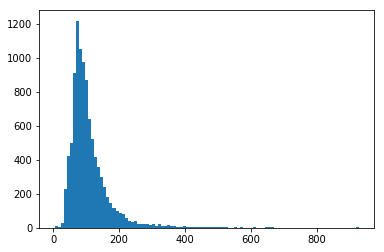

In [37]:
df_ads = df_ads.drop(df_ads[df_ads.bathrooms>=8].index)
df_ads = df_ads.drop(df_ads[df_ads.beds>=10].index)
df_ads = df_ads.drop(df_ads[df_ads.property_type=='site'].index)
df_ads.loc[df_ads['surface'] > 1000, 'surface'] = np.nan
df_ads = df_ads.drop(df_ads[df_ads.dist_to_centre > 30].index)

plt.hist(df_ads.surface, bins = 100)
plt.show()


Calculating and plotting the log price per square meter

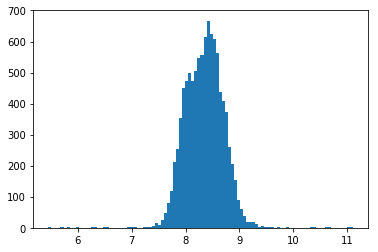

In [38]:
df_ads['price_sqm'] = np.log(df_ads.price / df_ads.surface)

plt.hist(df_ads.price_sqm, bins = 100)
plt.show()


Log transforming the price and plotting

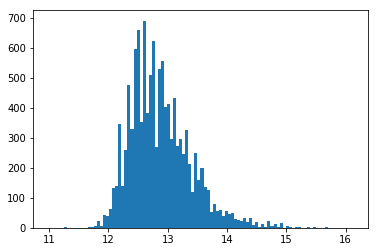

In [39]:
df_ads['price'] = np.log(df_ads.price)
plt.hist(df_ads.price, bins = 100)
plt.show()


Dropping rows with missing price

In [40]:
df_ads = df_ads.dropna(subset=['price'])


## Creating pipeline

Setting up a categorical transformer

In [41]:
categorical_features = ['area','property_type','ber_classification']
numeric_features = list(df_ads.columns)
for x in categorical_features:
    numeric_features.remove(x)
numeric_features.remove('price')
numeric_features.remove('price_sqm')
#numeric_features.remove('surface')

Categorical varibales are imputed with a 'missing' constant and dummies are created using OneHotEncoder

In [42]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


Transform numerical columns by imputing missing values and standardisation

In [43]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())])

Adding PCA to reduce dimensions

In [44]:
pca = PCA()

Combining the pipelines

In [45]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('pca', pca,[])])

steps = [('preprocessor', preprocessor),
         ('reg', LinearRegression())]

pipeline = Pipeline(steps)

## Fitting the model

In [46]:
#parametersGrid = {"preprocessor__num__imputer__strategy": ['mean','median'],
#                  "reg__alpha": np.linspace(0.00001, 10, 5),
#                  "reg__l1_ratio": np.linspace(0.00001, 1, 5)}
parametersGrid = {"preprocessor__num__imputer__strategy": ['mean','median'],
                  "preprocessor__pca__n_components":[1,2,3,4,5]}

#df_ads = df_ads.dropna(subset=['price_sqm'])
y = df_ads['price']
X = df_ads.drop(['price','price_sqm'], axis=1)
#X = df_ads.drop('surface', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

reg_cv = GridSearchCV(pipeline, parametersGrid, cv=5)

reg_cv.fit(X_train, y_train)

y_pred = reg_cv.predict(X_test)

r2 = reg_cv.score(X_test,y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Tuned best parameters: {}".format(reg_cv.best_params_))
print("Tuned R squared: {}".format(r2))
print("Tuned RMSE: {}".format(rmse))

Tuned best parameters: {'preprocessor__num__imputer__strategy': 'median', 'preprocessor__pca__n_components': 1}
Tuned R squared: 0.8626662263227514
Tuned RMSE: 0.19844040086234915


This shows that the median is a better imputer than the mean and that the optimal number of principal components is 1. 